In [1]:
#To freeze the environment for future
!pip freeze > requirements.txt

In [2]:
#pip install -r requirements.txt

## Business Problem

When a customer applies for a loan,the model needs to predict if a loan should be franted to an individual or not based on the data available.

`Loan ID	
Customer ID	
Loan Status	
Current Loan Amount	
Term	
Credit Score	
Years in current job
Home Ownership
Annual Income
Purpose
Monthly Debt
Years of Credit History
Months since last delinquent
Number of Open Accounts
Number of Credit Problems
Current Credit Balance
Maximum Open Credit
Bankruptcies
Tax Liens`


In [111]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import LabelBinarizer,StandardScaler,OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import boxcox
from sklearn.linear_model import LogisticRegression,RidgeClassifier, PassiveAggressiveClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from fancyimpute import KNN,SoftImpute
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import joblib

%matplotlib inline

In [112]:
import helper

In [113]:
#Reading the dataset
data=pd.read_csv("data\LoansTrainingSetV2.csv",low_memory=False)

# EDA

In [114]:
data.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Loan Refused,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Loan Refused,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Loan Refused,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,1244.02,16.7,32.0,11,1,11275,14815,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Loan Refused,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Loan Refused,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0


In [115]:
len(data)

111107

In [116]:
data.columns

Index(['Loan ID', 'Customer ID', 'Loan Status', 'Current Loan Amount', 'Term',
       'Credit Score', 'Years in current job', 'Home Ownership',
       'Annual Income', 'Purpose', 'Monthly Debt', 'Years of Credit History',
       'Months since last delinquent', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens'],
      dtype='object')

In [117]:
#Updating the column names to readable format
data.columns = ['Loan_ID', 'Customer_ID', 'Loan_Status', 'Curr_Loan_Amt', 'Term',
       'Credit_Score', 'Years_in_curr_job', 'Home_Ownership',
       'Annual_Income', 'Purpose', 'Monthly_Debt', 'Years_of_Credit_History',
       'Months_since_last_delinquent', 'Num_of_Open_Accounts',
       'Num_of_Credit_Problems', 'Curr_Credit_Balance',
       'Max_Open_Credit', 'Bankruptcies', 'Tax_Liens']

In [118]:
#Drop the duplicates with respect to LOAN ID
data.drop_duplicates(subset="Loan_ID", keep = 'first',inplace=True)

In [119]:
len(data)

88910

In [120]:
data["Loan_Status"].value_counts()/88910*100

Loan Given      71.687099
Loan Refused    28.312901
Name: Loan_Status, dtype: float64

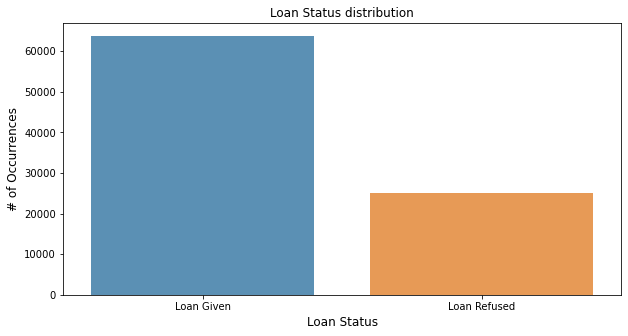

In [121]:
#Plotting the loan status
status=data["Loan_Status"].value_counts() 
plt.figure(figsize=(10,5))
sns.barplot(status.index, status.values, alpha=0.8)
plt.title('Loan Status distribution')
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Loan Status', fontsize=12)
plt.show()

,Curr_Loan_Amt,Credit_Score,Annual_Income,Years_of_Credit_History,Months_since_last_delinquent,Num_of_Open_Accounts,Num_of_Credit_Problems,Curr_Credit_Balance,Bankruptcies,Tax_Liens
Curr_Loan_Amt,1.000000,-0.135764,0.013253,0.013930,0.008060,0.001294,0.004312,0.003092,0.005162,0.001941
Credit_Score,-0.135764,1.000000,-0.021369,-0.017871,-0.006398,0.007580,0.003519,-0.001080,-0.001631,0.007496
Annual_Income,0.013253,-0.021369,1.000000,0.151185,-0.077611,0.139974,-0.013639,0.290915,-0.047587,0.042750
Years_of_Credit_History,0.013930,-0.017871,0.151185,1.000000,-0.041938,0.127471,0.061496,0.204948,0.064362,0.020711
Months_since_last_delinquent,0.008060,-0.006398,-0.077611,-0.041938,1.000000,-0.035860,0.098377,-0.028801,0.120603,0.007322
Num_of_Open_Accounts,0.001294,0.007580,0.139974,0.127471,-0.035860,1.000000,-0.014123,0.224165,-0.025339,0.007846
Num_of_Credit_Problems,0.004312,0.003519,-0.013639,0.061496,0.098377,-0.014123,1.000000,-0.107929,0.750943,0.589525
Curr_Credit_Balance,0.003092,-0.001080,0.290915,0.204948,-0.028801,0.224165,-0.107929,1.000000,-0.120020,-0.013179
Bankruptcies,0.005162,-0.001631,-0.047587,0.064362,0.120603,-0.025339,0.750943,-0.120020,1.000000,0.046017
Tax_Liens,0.001941,0.007496,0.042750,0.020711,0.007322,0.007846,0.589525,-0.013179,0.046017,1.000000


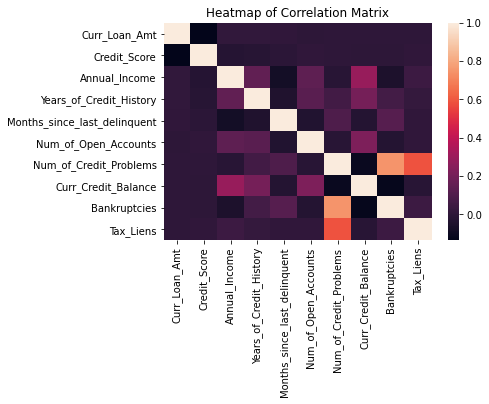

In [122]:
# Create a correlation matrix. What features correlate the most with turnover? What other correlations did you find?
corr = data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr

#### Let us go over each feature available in the dataset

##### 1. Current Loan Amount

In [123]:
data["Curr_Loan_Amt"].describe()

count    8.891000e+04
mean     1.433878e+07
std      3.502996e+07
min      4.910000e+02
25%      8.283000e+03
50%      1.435500e+04
75%      2.448500e+04
max      1.000000e+08
Name: Curr_Loan_Amt, dtype: float64

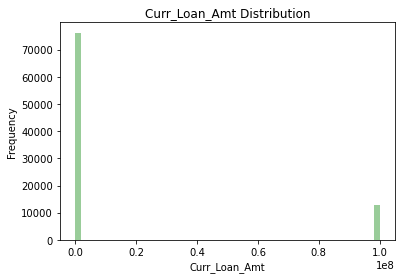

In [124]:
#f, axes = plt.subplots(ncols=2, figsize=(15, 6))
# Graph Current Loan Amount
sns.distplot(data.Curr_Loan_Amt, kde=False, color="g").set_title('Curr_Loan_Amt Distribution')
plt.ylabel('Frequency');

In [125]:
#Finding IQR's for outlier removal

Q1 = data["Curr_Loan_Amt"].quantile(0.25)
Q3 = data["Curr_Loan_Amt"].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

16202.0


In [126]:
#Current Loan Amount outliers
data["Curr_Loan_Amt"][((data["Curr_Loan_Amt"] < (Q1 - 1.5 * IQR)) |(data["Curr_Loan_Amt"] > (Q3 + 1.5 * IQR)))]

5044     99999999
5045     99999999
5046     99999999
5047     99999999
5048     99999999
           ...   
17777    99999999
17778    99999999
17779    99999999
17780    99999999
17781    99999999
Name: Curr_Loan_Amt, Length: 12738, dtype: int64

In [127]:
temp=np.array(data["Curr_Loan_Amt"].values.tolist())
data["Current Loan Amount_temp"] = np.where(temp > 9999998, 'NaN', temp).tolist()

count    76172.000000
mean     13933.915756
std       8235.921922
min        491.000000
25%       7810.000000
50%      12038.000000
75%      19351.000000
max      35875.000000
Name: Current Loan Amount_temp, dtype: float64

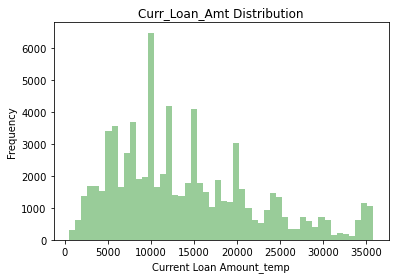

In [128]:
temp=data["Current Loan Amount_temp"][data["Current Loan Amount_temp"]!='NaN'].astype(str).astype(int)
#Plot the Current Loan Amount after clean up
sns.distplot(temp, kde=False, color="g").set_title('Curr_Loan_Amt Distribution')
plt.ylabel('Frequency');
                   
temp.describe()

In [129]:
#Replacing the data with 50% percentile or mean
temp=np.array(data["Curr_Loan_Amt"].values.tolist())
data["Curr_Loan_Amt"] = np.where(temp > 9999998,12038,temp).tolist()

data=data.drop(['Current Loan Amount_temp'],axis=1)

##### 2. Term

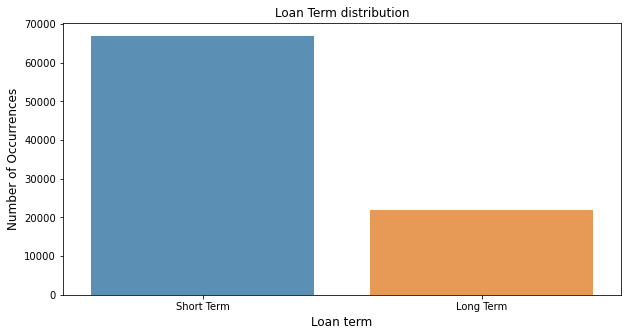

In [130]:
status=data["Term"].value_counts() 
# Graph Term

plt.figure(figsize=(10,5))
sns.barplot(status.index, status.values, alpha=0.8)
plt.title('Loan Term distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan term', fontsize=12)
plt.show()

##### 3. Credit Score

In [131]:
data["Credit_Score"].describe()

count    67572.000000
mean      1199.199580
std       1680.813805
min        585.000000
25%        714.000000
50%        733.000000
75%        744.000000
max       7510.000000
Name: Credit_Score, dtype: float64

Max Credit Score available in the dataset is 7510. The range for Credit Score is 0-800

C:\Users\Vsh\.conda\envs\DS\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\Vsh\.conda\envs\DS\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\Vsh\.conda\envs\DS\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\Vsh\.conda\envs\DS\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


{'whiskers': [<matplotlib.lines.Line2D at 0x215f427dc08>,
 'caps': [<matplotlib.lines.Line2D at 0x215f427a5c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x215f427d408>],
 'medians': [<matplotlib.lines.Line2D at 0x215f4275748>],
 'fliers': [<matplotlib.lines.Line2D at 0x215f4275048>],
 'means': []}

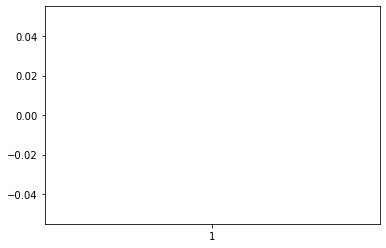

In [132]:
plt.boxplot(data["Credit_Score"])

In [133]:
data["Credit_Score"].isnull().unique()

array([False,  True])

In [134]:
#Shows there are missing values in the data

#Now lets do treatment of the data at hand. Let us firstly divide the values greater than 800 by 10

data["Credit_Score"]=np.where(data["Credit_Score"]>800, data["Credit_Score"]/10, data["Credit_Score"])

In [135]:
#Now lets replace the missing values with median 
median_score=statistics.median(data["Credit_Score"])

data["Credit Score_1"]=data["Credit_Score"]
data["Credit Score_1"].fillna(median_score, inplace = True) 

In [136]:
median_score

685.0

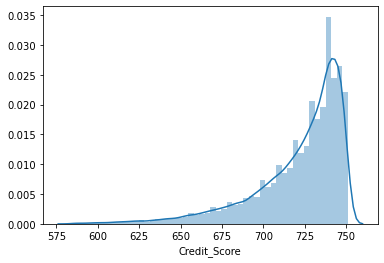

In [139]:
sns.distplot(data["Credit_Score"]);

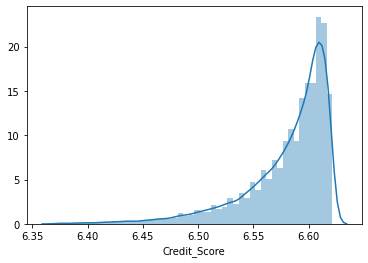

In [142]:
sns.distplot(np.log(data["Credit_Score"]));

##### 4. Home Ownership

In [146]:
data['Home_Ownership'].unique()

array(['Rent', 'Home Mortgage', 'Own Home', 'HaveMortgage'], dtype=object)

We can see it has Home Mortgage and haveMortgage as 2 different classes. Let's replace 'HaveMortgage' with 'Home Mortgage'

In [148]:
data['Home_Ownership']=data['Home_Ownership'].str.replace('HaveMortgage', 'Home Mortgage', regex=True)

In [149]:
data['Home_Ownership'].unique()

array(['Rent', 'Home Mortgage', 'Own Home'], dtype=object)

##### Annual Income

In [151]:
data['Annual_Income'].describe()

count    6.757200e+04
mean     7.234575e+04
std      5.836101e+04
min      4.033000e+03
25%      4.458600e+04
50%      6.149400e+04
75%      8.675025e+04
max      8.713547e+06
Name: Annual_Income, dtype: float64

In [153]:
##Lets look at the quantiles for this feature

data['Annual_Income'].quantile([.2,0.75,0.90,.95,0.99,.999])


0.200     40764.00
0.750     86750.25
0.900    119916.00
0.950    147645.00
0.990    239286.96
0.999    491575.77
Name: Annual_Income, dtype: float64

In [154]:
#As we can see they lie in the 99th percentile of the data.Lets replace them
# Capping any values greater than 99% to 99th value
data.loc[data['Annual_Income'] > 239287, 'Annual_Income'] = 239287


In [155]:
data['Annual_Income'].isna().sum()
#So we have about 21000 null values 

##We will impute the mising data with other columns towards the end

21338

In [ ]:
###############Loan Purpose ###############

data['Purpose'].value_counts()

In [ ]:
#So other and Other mean the same thing. Lets make it the same

data['Purpose']=data['Purpose'].str.replace('Other', 'other', regex=True)

In [ ]:
#######Monthly debt ###############


data['Monthly Debt'].describe()
##So this is not numeric column. Lets explore

In [ ]:
data['Monthly Debt'] 
# But this should be a numeric column. So lets convert it to float

In [ ]:
pd.to_numeric(data['Monthly Debt'] )
#As we can see there is a $ symbol present. Lets replace it 

In [ ]:
data['Monthly Debt']=data['Monthly Debt'].str.replace('$', '', regex=True)

data['Monthly Debt']=pd.to_numeric(data['Monthly Debt'] )

sns.distplot(data["Monthly Debt"])

In [ ]:
#We can see that there are outliers in this data because of the plot
#Lets explore

data['Monthly Debt'].describe()
#The max value is too high here

In [ ]:
data['Monthly Debt'].quantile([.2,0.75,0.90,.95,0.99,.999])

In [ ]:
#Problem is with 99th percentile. lets dig deeper

data['Monthly Debt'].quantile([0.9995,.9999])
#So problem again is wit 99th percentile

In [ ]:
data['Monthly Debt'].quantile([0.9997,.99999])
#0.99970     5978.574911
#0.99999    13262.762330

In [ ]:
data['Monthly Debt'].quantile([0.999,1])
#0.999     4926.37475
#1.000    22939.12000
#Need to replace this

In [ ]:
data.loc[data['Monthly Debt'] > 4926, 'Monthly Debt'] = 4926

In [ ]:
sns.distplot(data["Monthly Debt"])

#Now we get the right distribution

In [ ]:
####################Years of credit history #################

data['Years of Credit History'].value_counts()


sns.distplot(data["Years of Credit History"])
#Over all looks pretty clean! no need of doing anything

In [ ]:
#############Months since last delinquent####################

data['Months since last delinquent'].describe()

In [ ]:
#Lets check if there are any NA's
data['Months since last delinquent'].isna().sum()
#We have nearly 48506 NA;s. We will try to handle them at last 

In [ ]:
##############Number of open accounts ##############

data['Number of Open Accounts'].describe()
#The max number seems odd. Lets investigate

In [ ]:
sns.distplot(data['Number of Open Accounts'])
#Yes there are outliers in this columns. Let dig deeper

In [ ]:
data['Number of Open Accounts'].quantile([0.75,0.999,1])
#Ok so replacing anything greater than 99th percentile with 99th percentile values

In [ ]:
data.loc[data['Number of Open Accounts'] > 36, 'Number of Open Accounts'] = 36

In [ ]:
sns.distplot(data['Number of Open Accounts'])
#Looks good now

In [ ]:
#######################Number of Credit problems##############

data['Number of Credit Problems'].describe() 
#Max looks a bit higher. Lets see

In [ ]:
sns.distplot(data['Number of Credit Problems'])
#Okay lets look at value _counts

In [ ]:
data['Number of Credit Problems'].value_counts()

#Okay looks good

In [ ]:
##################Current Credit Balance###########

data['Current Credit Balance'].describe()

In [ ]:
sns.distplot(data['Current Credit Balance'])
#It seems there are outliers in this data. Lets investigate

In [ ]:
data['Current Credit Balance'].quantile([0.75,0.95,0.999,1])

#0.750      19301.000
#0.950      39933.300
#0.999     227670.033
#1.000    1730472.000

In [ ]:
#lets dig deeper

data['Current Credit Balance'].quantile([0.95,0.96,0.97,0.98,0.99,1])

In [ ]:
#So lets replace it with 95th percentile

data['Current Credit Balance'].quantile([0.55,0.76,0.87,0.98,0.99,1])

In [ ]:
data.loc[data['Current Credit Balance'] > 81007, 'Current Credit Balance'] = 81007

In [ ]:
sns.distplot(data['Current Credit Balance']**(1/2))
#The plot doesnt look good. We need to transform it

data['Current Credit Balance']=data['Current Credit Balance']**(1/2)

In [ ]:
#######################Max open credit################

data['Maximum Open Credit'].describe()

In [ ]:
data['Maximum Open Credit'].value_counts()

In [ ]:
sns.distplot(data['Maximum Open Credit'])
#So there are some str characters present in the data. Lets find them

In [ ]:
pd.to_numeric(data['Maximum Open Credit'])

In [ ]:
#Lets replace #value with Nan
data['Maximum Open Credit']=data['Maximum Open Credit'].replace('#VALUE!', np.nan, regex=True)
    
data['Maximum Open Credit']=pd.to_numeric(data['Maximum Open Credit'])

In [ ]:
data['Maximum Open Credit'].isnull().sum()
#Now we have only 2 Nan;s in the data. Lets replace them with mean

In [ ]:
  
data['Maximum Open Credit']=data['Maximum Open Credit'].fillna(35965)

In [ ]:
data['Maximum Open Credit'].quantile([0.55,0.76,0.87,0.98,0.99,1])

In [ ]:
#Lets replace the outliers


data.loc[data['Maximum Open Credit'] > 171423, 'Maximum Open Credit'] = 171423

#Looks much better now

In [ ]:
data['Maximum Open Credit'].describe()

In [ ]:
###############Bankruptcies##########
data['Bankruptcies'].describe()

In [ ]:
data['Bankruptcies'].value_counts()

In [ ]:
data['Bankruptcies'].unique()

In [ ]:
#So we have Nan's. Lets fill them with median

data['Bankruptcies']=data['Bankruptcies'].fillna(3)


In [ ]:
#Looks good
data['Bankruptcies'].unique()

In [ ]:
####Tax Liens######

data['Tax Liens'].describe()

In [ ]:
data['Tax Liens'].value_counts()

In [ ]:
data['Bankruptcies'].unique()


###Looks good

In [ ]:
################Now we will impute missing values to the columns which have NA's ####################

###Converting all the categorical columns into numbers

cat_cols = ['Term','Years in current job','Home Ownership','Purpose']

for c in cat_cols:
    data[c] = pd.factorize(data[c])[0]

In [ ]:
#Imputing missing data with soft impute
#Soft impute by default has 100 iterations.
updated_data=pd.DataFrame(data=SoftImpute().fit_transform(data[data.columns[3:19]],), columns=data[data.columns[3:19]].columns, index=data.index)

In [ ]:
data.head()

In [ ]:
updated_data.head()

In [ ]:
#Getting the dataset ready pd.get dummies function for dropping the dummy variables
df_LC = pd.get_dummies(updated_data, drop_first=True)
#df_LC['Loan_Status']=data['Loan Status']

In [ ]:
df_LC1 = pd.get_dummies(updated_data)

In [ ]:
#Binarizing the Target variable
lb_style = LabelBinarizer()
lb_results = lb_style.fit_transform(data['Loan Status'])
y=lb_results

In [ ]:
y.shape

In [ ]:
y=y.ravel()

In [ ]:
y.shape

In [ ]:
#Scaling the independent variables
X_scaled = preprocessing.scale(df_LC)
print(X_scaled)
print('   ')
print(X_scaled.shape)

In [ ]:
import operator
#######Looking at other models using different classifiers
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=22)

In [ ]:
#Finding accuracy and feature importance using XGB classifier
xgb0, y_pred_b, y_pred2_b = classify(XGBClassifier(), X_train, y_train,X_test,y_test)

In [ ]:
print(xgb0.feature_importances_)
plot_importance(xgb0)
pyplot.show()
feat1 = feat_importance(xgb0)
display(feat1)
xgb0, y_pred_b, y_pred2_b = classify(XGBClassifier(n_estimators=47, learning_rate=0.015), X_train, y_train,X_test,y_test)

In [ ]:
#######K nearest Neighbour classifier ################

knc, y_p, y_p2 = classify(KNeighborsClassifier(), X_train, y_train,X_test,y_test)

In [ ]:
########Logistic Regression ##############
logit, y_p, y_p2 = classify(LogisticRegression(), X_train, y_train,X_test,y_test)

In [ ]:
########Decision Tree Classifier ##########
dtc, y_p, y_p2 = classify(DecisionTreeClassifier(), X_train2, y_train2,X_test,y_test)

In [ ]:
#########Running on unbalanced dataset #############

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)
models_report, conf_matrix = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')


models_report

In [ ]:
display(conf_matrix)

In [ ]:
###########Synthetically balancing the dataset##################

index_split = int(len(X_scaled)/2)
X_train, y_train = SMOTE().fit_sample(X_scaled[0:index_split, :], y[0:index_split])
X_test, y_test = X_scaled[index_split:], y[index_split:]

models_report_bal, conf_matrix_bal = run_models(X_train, y_train, X_test, y_test, model_type = 'Balanced')

In [ ]:
################Now we  know that GBM model performed the best so 
# save model
gbm=GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3)
gbm.fit(X_scaled, y)

In [ ]:
joblib.dump(gbm, 'GBM_Model_version1.pkl')
# load model
#gbm_pickle = joblib.load('GBM_Model_version1.pkl')